Preparing Data Cleaning for User Analytics


Start by importing libaries

In [1]:
import numpy as nm
from pandas import *
import pandas as pa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sklearn.impute
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

 Then we import "field description" to see what data is presenting:

In [43]:
mydata_columns = pa.read_excel('..\data\Field Descriptions.xlsx', na_values=['?', None])

In [44]:
mydata_columns.head()

,Fields,Description
0,bearer id,xDr session identifier
1,Dur. (ms),Total Duration of the xDR (in ms)
2,Start,Start time of the xDR (first frame timestamp)
3,Start ms,Milliseconds offset of start time for the xDR ...
4,End,End time of the xDR (last frame timestamp)


In [4]:
print(f" There are {mydata_columns.shape[0]} rows and {mydata_columns.shape[1]} columns")

 There are 56 rows and 2 columns


Now we import our dataset (source data):

In [45]:
import warnings
warnings.filterwarnings('ignore')
pa.set_option('display.max_column', None)
ds = pa.read_excel('..\data\Week1_challenge_data_source.xlsx', na_values=['?', None])

In [46]:
pa.set_option('display.float_format', lambda x: '% 0.2f'% x)

In [7]:
ds.size

8250055

In [40]:
ds.head(5)
ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Bearer Id,149010.00,10138874654256340992.00,2893172512268411392.00,6917537518543529984.00,7349883246953990144.00,7349883264156584960.00,13042425978957576192.00,13186541167134199808.00
Start ms,150000.00,499.19,288.61,0.00,250.00,499.00,749.00,999.00
End ms,150000.00,498.80,288.10,0.00,251.00,500.00,750.00,999.00
Dur. (ms),150000.00,104608.56,81037.62,7142.00,57440.50,86399.00,132430.25,1859336.00
IMSI,149431.00,208201639651669.06,21488090841.37,204047108489451.00,208201401263249.00,208201546329113.00,208201771619103.00,214074303349628.00
MSISDN/Number,148935.00,41882819545.03,2447443358621.67,33601001722.00,33651295581.50,33663706799.00,33683490769.00,882397108489451.00
IMEI,149429.00,48474547977654.53,22416372027957.56,440015202000.00,35460708865439.00,35722009426311.00,86119704674953.00,99001201327774.00
Avg RTT DL (ms),122172.00,109.80,619.78,0.00,32.00,45.00,70.00,96923.00
Avg RTT UL (ms),122189.00,17.66,84.79,0.00,2.00,5.00,15.00,7120.00
Avg Bearer TP DL (kbps),150000.00,13300.05,23971.88,0.00,43.00,63.00,19710.75,378160.00


In [35]:
#ds.columns.tolist()

In [10]:
print(f" There are {ds.shape[0]} rows and {ds.shape[1]} columns")

 There are 150001 rows and 55 columns


In [11]:
ds.info()
# ds.describe(include=[nm.number])
# ds.describe(include=[object])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype         
---  ------                                    --------------   -----         
 0   Bearer Id                                 149010 non-null  float64       
 1   Start                                     150000 non-null  datetime64[ns]
 2   Start ms                                  150000 non-null  float64       
 3   End                                       150000 non-null  datetime64[ns]
 4   End ms                                    150000 non-null  float64       
 5   Dur. (ms)                                 150000 non-null  float64       
 6   IMSI                                      149431 non-null  float64       
 7   MSISDN/Number                             148935 non-null  float64       
 8   IMEI                                      149429 non-null  float64       
 9   Last Location N

Look at what is missing:

In [13]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(ds):

    # Calculate total number of cells in dataframe
    totalCells = nm.product(ds.shape)
    #print(totalCells)

    # Count number of missing values per column
    missingCount = ds.isnull().sum()
    print(missingCount)

    # Calculate total number of missing values
    totalMissing = missingCount.sum()
    #print(totalMissing)

    # Calculate percentage of missing values
    print("The User Analytic dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

percent_missing(ds)

Bearer Id                                      991
Start                                            1
Start ms                                         1
End                                              1
End ms                                           1
Dur. (ms)                                        1
IMSI                                           570
MSISDN/Number                                 1066
IMEI                                           572
Last Location Name                            1153
Avg RTT DL (ms)                              27829
Avg RTT UL (ms)                              27812
Avg Bearer TP DL (kbps)                          1
Avg Bearer TP UL (kbps)                          1
TCP DL Retrans. Vol (Bytes)                  88146
TCP UL Retrans. Vol (Bytes)                  96649
DL TP < 50 Kbps (%)                            754
50 Kbps < DL TP < 250 Kbps (%)                 754
250 Kbps < DL TP < 1 Mbps (%)                  754
DL TP > 1 Mbps (%)             

In [14]:
num_missing = ds.isnull().sum()
shape = ds.shape
num_rows = ds.shape[0]

data = {
    'num_missing': num_missing, 
    'percent_missing (%)': [round(x,2) for x in num_missing/num_rows*100]
}

temp = pa.DataFrame(data)

In [15]:
temp[temp['num_missing'] != 0]

,num_missing,percent_missing (%)
Bearer Id,991,0.660
Start,1,0.000
Start ms,1,0.000
End,1,0.000
End ms,1,0.000
Dur. (ms),1,0.000
IMSI,570,0.380
MSISDN/Number,1066,0.710
IMEI,572,0.380
Last Location Name,1153,0.770


In [47]:
large_missing = temp[temp['percent_missing (%)'] > 50].index.to_list()
ds_dropped = ds.drop(large_missing, axis=1)

In [48]:
ds_dropped.shape

(150001, 45)

In [73]:
#looking at the datatypes we have float of object and datetime
numerical_columns = []
category_columns = []
datetime_columns = []

for col in ds_dropped.columns:
    if ds_dropped[col].dtype in ['float64']:
        numerical_columns.append(col)
    elif ds_dropped[col].dtype == object:
        category_columns.append(col)
    else:
        datetime_columns.append(col)
        
        
features = numerical_columns+category_columns+datetime_columns
ds_edited = ds_dropped[features]
ds_edited.head(5)

,Bearer Id,Start ms,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Avg RTT DL (ms),Avg RTT UL (ms),Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps),DL TP < 50 Kbps (%),50 Kbps < DL TP < 250 Kbps (%),250 Kbps < DL TP < 1 Mbps (%),DL TP > 1 Mbps (%),UL TP < 10 Kbps (%),10 Kbps < UL TP < 50 Kbps (%),50 Kbps < UL TP < 300 Kbps (%),UL TP > 300 Kbps (%),Activity Duration DL (ms),Activity Duration UL (ms),Dur. (ms).1,Nb of sec with Vol DL < 6250B,Nb of sec with Vol UL < 1250B,Social Media DL (Bytes),Social Media UL (Bytes),Google DL (Bytes),Google UL (Bytes),Email DL (Bytes),Email UL (Bytes),Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Last Location Name,Handset Manufacturer,Handset Type,Start,End
0,13114483460844900352.00,770.00,662.00,1823652.00,208201448079117.00,33664962239.00,35521209507511.00,42.00,5.00,23.00,44.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,37624.00,38787.00,1823652892.00,213.00,214.00,1545765.00,24420.00,1634479.00,1271433.00,3563542.00,137762.00,15854611.00,2501332.00,8198936.00,9656251.00,278082303.00,14344150.00,171744450.00,8814393.00,36749741.00,308879636.00,9164566995485190,Samsung,Samsung Galaxy A5 Sm-A520F,2019-04-04 12:01:18,2019-04-25 14:35:31
1,13114483482878900224.00,235.00,606.00,1365104.00,208201909211140.00,33681854413.00,35794009006359.00,65.00,5.00,16.00,26.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,168.00,3560.00,1365104371.00,971.00,1022.00,1926113.00,7165.00,3493924.00,920172.00,629046.00,308339.00,20247395.00,19111729.00,18338413.00,17227132.00,608750074.00,1170709.00,526904238.00,15055145.00,53800391.00,653384965.00,L77566A,Samsung,Samsung Galaxy J5 (Sm-J530),2019-04-09 13:04:04,2019-04-25 08:15:48
2,13114483484080500736.00,1.00,652.00,1361762.00,208200314458056.00,33760627129.00,35281510359387.00,NaN,NaN,6.00,9.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,1361762651.00,751.00,695.00,1684053.00,42224.00,8535055.00,1694064.00,2690151.00,672973.00,19725661.00,14699576.00,17587794.00,6163408.00,229584621.00,395630.00,410692588.00,4215763.00,27883638.00,279807335.00,D42335A,Samsung,Samsung Galaxy A8 (2018),2019-04-09 17:42:11,2019-04-25 11:58:13
3,13114483485442799616.00,486.00,171.00,1321509.00,208201402342131.00,33750343200.00,35356610164913.00,NaN,NaN,44.00,44.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,3330.00,37882.00,1321509685.00,17.00,207.00,644121.00,13372.00,9023734.00,2788027.00,1439754.00,631229.00,21388122.00,15146643.00,13994646.00,1097942.00,799538153.00,10849722.00,749039933.00,12797283.00,43324218.00,846028530.00,T21824A,undefined,undefined,2019-04-10 00:31:25,2019-04-25 07:36:35
4,13114483499480700928.00,565.00,954.00,1089009.00,208201401415120.00,33699795932.00,35407009745539.00,NaN,NaN,6.00,9.00,100.00,0.00,0.00,0.00,100.00,0.00,0.00,0.00,0.00,0.00,1089009389.00,607.00,604.00,862600.00,50188.00,6248284.00,1500559.00,1936496.00,173853.00,15259380.00,18962873.00,17124581.00,415218.00,527707248.00,3529801.00,550709500.00,13910322.00,38542814.00,569138589.00,D88865A,Samsung,Samsung Sm-G390F,2019-04-12 20:10:23,2019-04-25 10:40:32


In [53]:
ds_edited.dtypes

Bearer Id                                float64
Start ms                                 float64
End ms                                   float64
Dur. (ms)                                float64
IMSI                                     float64
MSISDN/Number                            float64
IMEI                                     float64
Avg RTT DL (ms)                          float64
Avg RTT UL (ms)                          float64
Avg Bearer TP DL (kbps)                  float64
Avg Bearer TP UL (kbps)                  float64
DL TP < 50 Kbps (%)                      float64
50 Kbps < DL TP < 250 Kbps (%)           float64
250 Kbps < DL TP < 1 Mbps (%)            float64
DL TP > 1 Mbps (%)                       float64
UL TP < 10 Kbps (%)                      float64
10 Kbps < UL TP < 50 Kbps (%)            float64
50 Kbps < UL TP < 300 Kbps (%)           float64
UL TP > 300 Kbps (%)                     float64
Activity Duration DL (ms)                float64
Activity Duration UL

In [55]:
null = ds_edited[numerical].isna().sum().sort_values(ascending = True)
null_per = (null/150001) * 100
null_percentage = pa.DataFrame(null_per)
null_percentage

,0
Youtube DL (Bytes),0.00
Other UL (Bytes),0.00
Other DL (Bytes),0.00
Gaming UL (Bytes),0.00
Gaming DL (Bytes),0.00
Netflix UL (Bytes),0.00
Netflix DL (Bytes),0.00
Youtube UL (Bytes),0.00
Email UL (Bytes),0.00
Email DL (Bytes),0.00


In [74]:
ds_edited['Last Location Name'].fillna(ds_edited['Last Location Name'].mode()[0], inplace=True)
ds_edited['Handset Type'].fillna(ds_edited['Handset Type'].mode()[0], inplace=True)
ds_edited['Handset Manufacturer'].fillna(ds_edited['Handset Manufacturer'].mode()[0], inplace=True)
ds_edited['IMSI'].fillna(ds_edited['IMSI'].mode()[0], inplace=True)
ds_edited['IMEI'].fillna(ds_edited['IMEI'].mode()[0], inplace=True)
ds_edited['Start ms'].fillna(ds_edited['Start ms'].mode()[0], inplace=True)
ds_edited['End ms'].fillna(ds_edited['End ms'].mode()[0], inplace=True)
ds_edited['Dur. (ms)'].fillna(ds_edited['Dur. (ms)'].mode()[0], inplace=True)
ds_edited['Avg Bearer TP DL (kbps)'].fillna(ds_edited['Avg Bearer TP DL (kbps)'].mode()[0], inplace=True)
ds_edited['Avg Bearer TP UL (kbps)'].fillna(ds_edited['Avg Bearer TP UL (kbps)'].mode()[0], inplace=True)
ds_edited['Avg Bearer TP UL (kbps)'].fillna(ds_edited['Avg Bearer TP UL (kbps)'].mode()[0], inplace=True)
ds_edited['Avg Bearer TP UL (kbps)'].fillna(ds_edited['Avg Bearer TP UL (kbps)'].mode()[0], inplace=True)
ds_edited['Activity Duration DL (ms)'].fillna(ds_edited['Activity Duration DL (ms)'].mode()[0], inplace=True)
ds_edited['Activity Duration UL (ms)'].fillna(ds_edited['Activity Duration UL (ms)'].mode()[0], inplace=True)
ds_edited['Dur. (ms).1'].fillna(ds_edited['Dur. (ms).1'].mode()[0], inplace=True)

ds_edited['Start'] = pa.to_datetime(ds['Start'])
ds_edited['End'] = pa.to_datetime(ds['End'])

In [76]:
imputer = SimpleImputer(missing_values=nm.nan, strategy='mean')
imputer.fit(ds_edited['Avg RTT DL (ms)'].values.reshape(-1, 1))
ds_edited['Bearer Id'] = imputer.transform(ds_edited['Bearer Id'].values.reshape(-1, 1))
ds_edited['Avg RTT DL (ms)'] = imputer.transform(ds_edited['Avg RTT DL (ms)'].values.reshape(-1, 1))
ds_edited['Total DL (Bytes)'] = imputer.transform(ds_edited['Total DL (Bytes)'].values.reshape(-1, 1))
ds_edited['Total UL (Bytes)'] = imputer.transform(ds_edited['Total UL (Bytes)'].values.reshape(-1, 1))
ds_edited['Avg RTT UL (ms)'] = imputer.transform(ds_edited['Avg RTT UL (ms)'].values.reshape(-1, 1))
ds_edited['DL TP < 50 Kbps (%)'] = imputer.transform(ds_edited['DL TP < 50 Kbps (%)'].values.reshape(-1, 1))
ds_edited['50 Kbps < DL TP < 250 Kbps (%)'] = imputer.transform(ds_edited['50 Kbps < DL TP < 250 Kbps (%)'].values.reshape(-1, 1))
ds_edited['250 Kbps < DL TP < 1 Mbps (%)'] = imputer.transform(ds_edited['250 Kbps < DL TP < 1 Mbps (%)'].values.reshape(-1, 1))
ds_edited['DL TP > 1 Mbps (%)'] = imputer.transform(ds_edited['DL TP > 1 Mbps (%)'].values.reshape(-1, 1))
ds_edited['UL TP < 10 Kbps (%)'] = imputer.transform(ds_edited['UL TP < 10 Kbps (%)'].values.reshape(-1, 1))
ds_edited['10 Kbps < UL TP < 50 Kbps (%)'] = imputer.transform(ds_edited['10 Kbps < UL TP < 50 Kbps (%)'].values.reshape(-1, 1))
ds_edited['50 Kbps < UL TP < 300 Kbps (%)'] = imputer.transform(ds_edited['50 Kbps < UL TP < 300 Kbps (%)'].values.reshape(-1, 1))
ds_edited['UL TP > 300 Kbps (%)'] = imputer.transform(ds_edited['UL TP > 300 Kbps (%)'].values.reshape(-1, 1))
ds_edited['Nb of sec with Vol DL < 6250B'] = imputer.transform(ds_edited['Nb of sec with Vol DL < 6250B'].values.reshape(-1, 1))
ds_edited['Nb of sec with Vol UL < 1250B'] = imputer.transform(ds_edited['Nb of sec with Vol UL < 1250B'].values.reshape(-1, 1))

# ds_edited.isnull().sum()

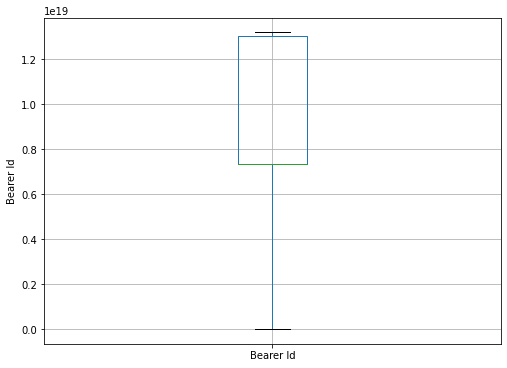

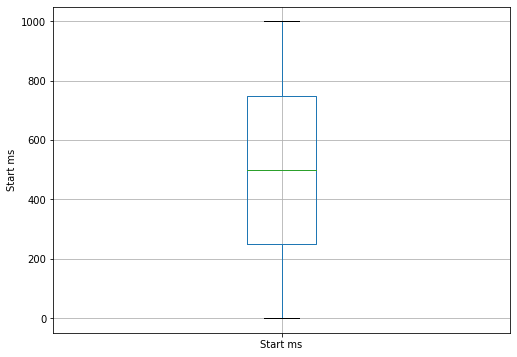

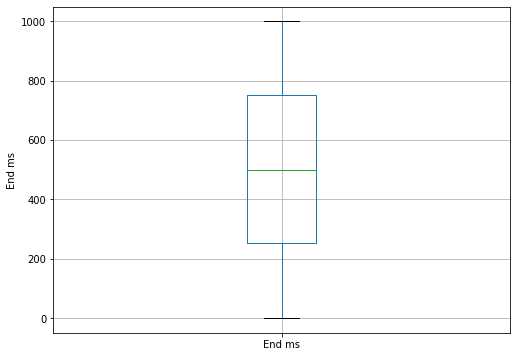

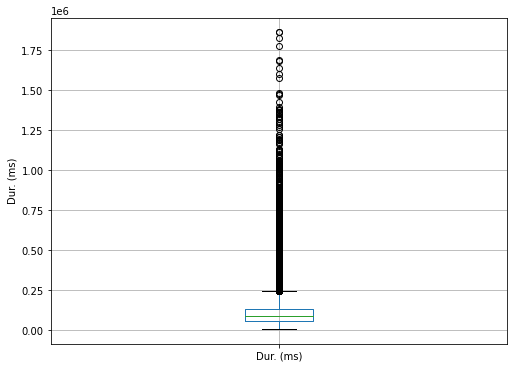

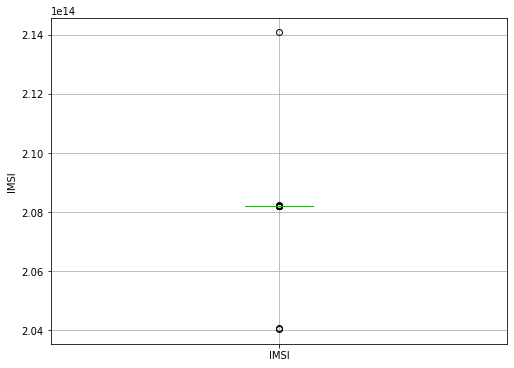

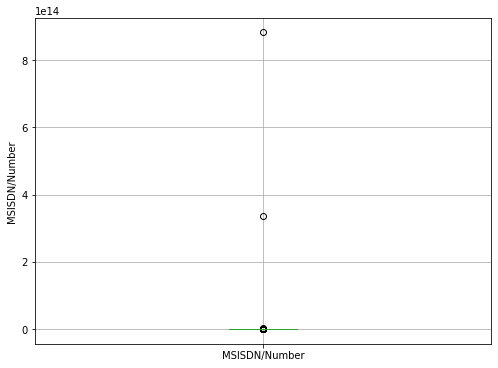

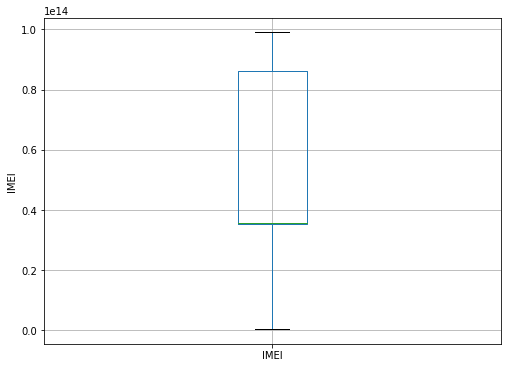

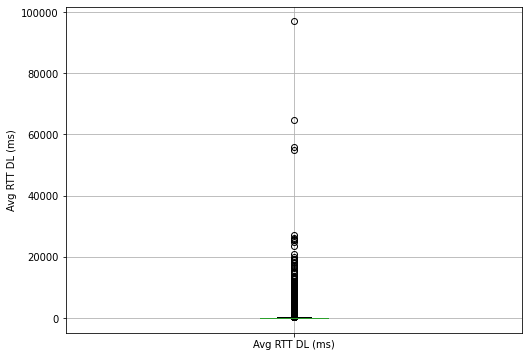

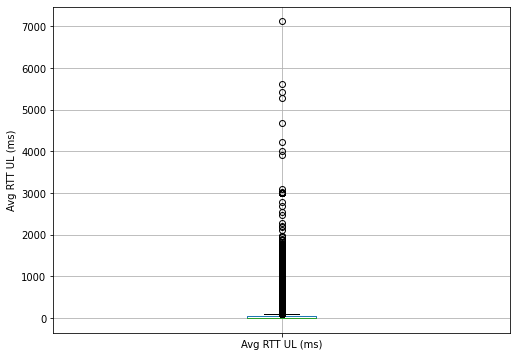

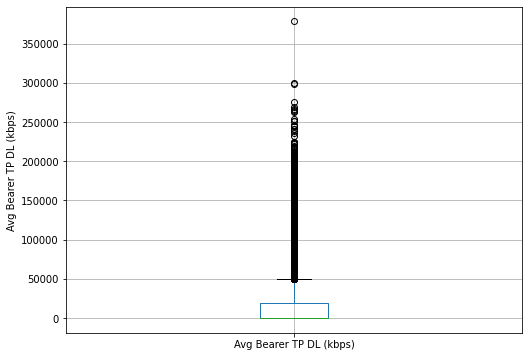

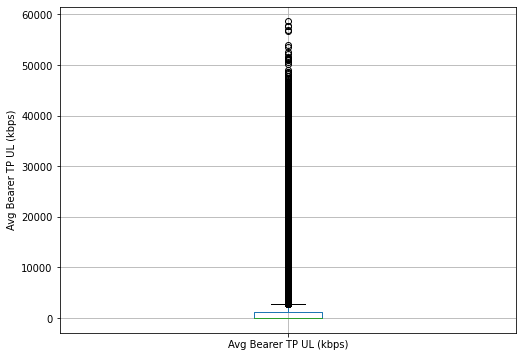

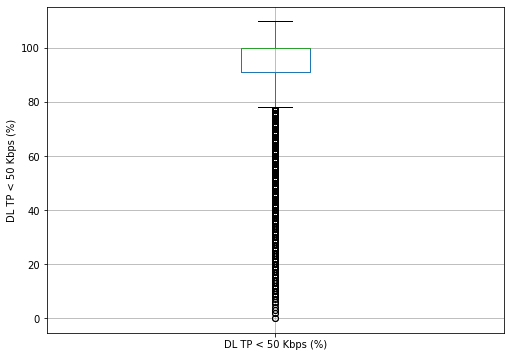

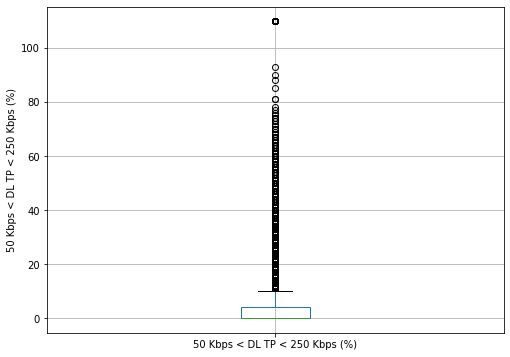

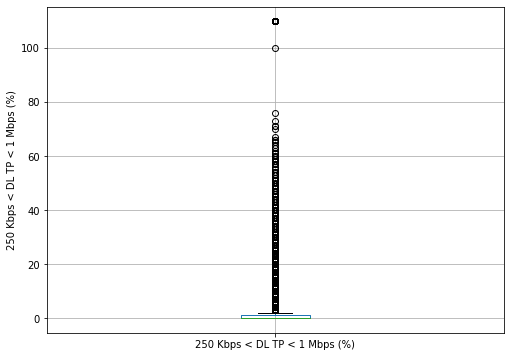

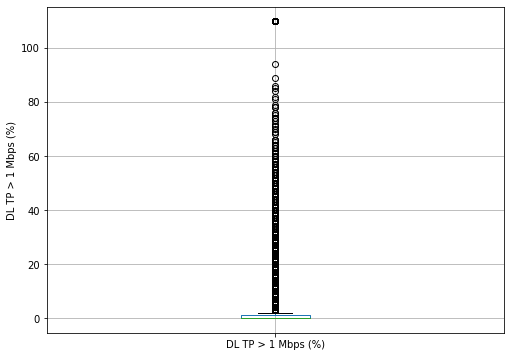

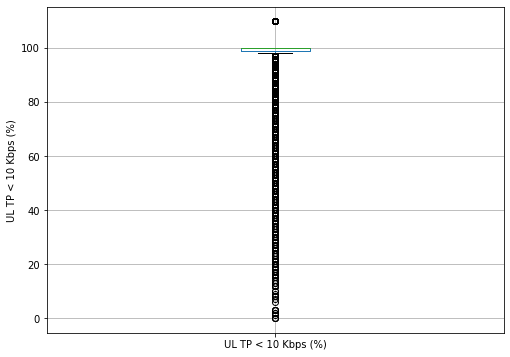

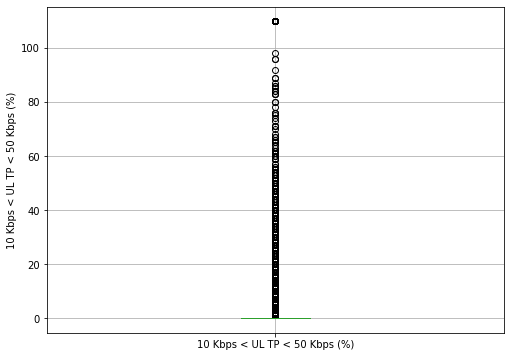

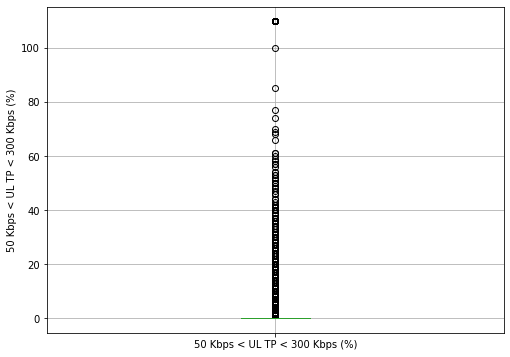

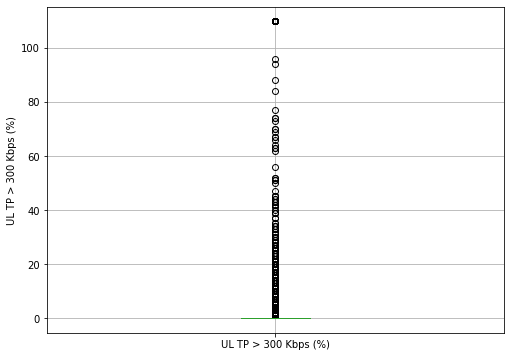

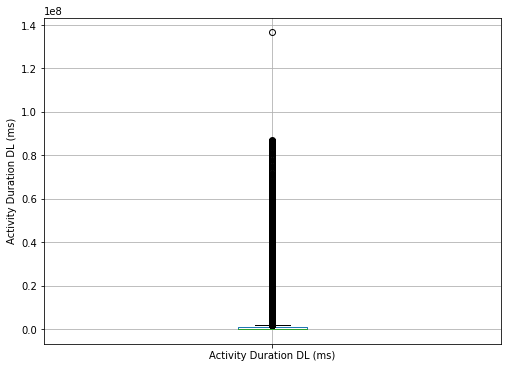

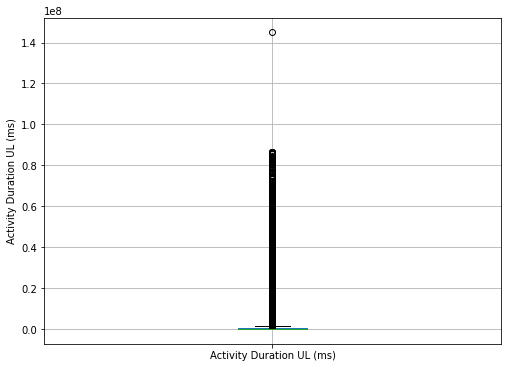

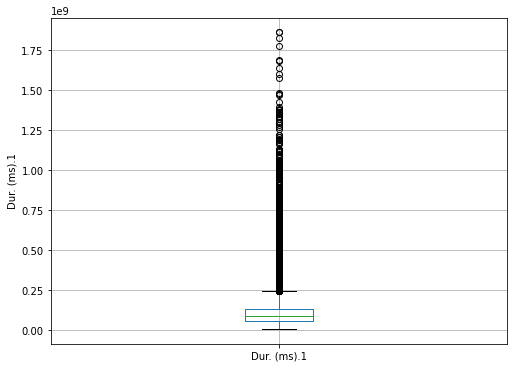

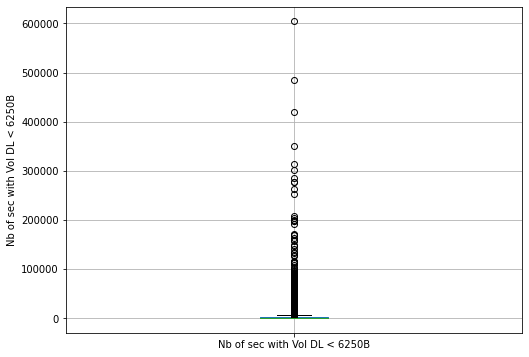

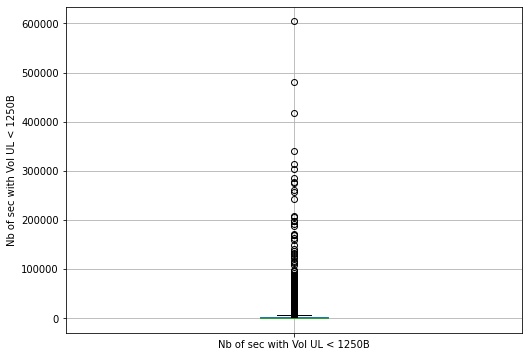

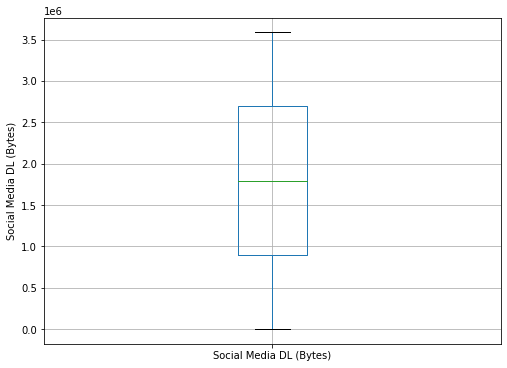

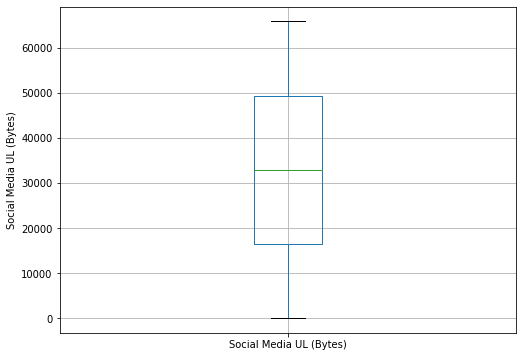

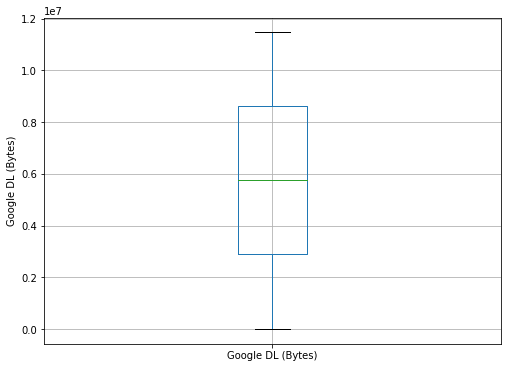

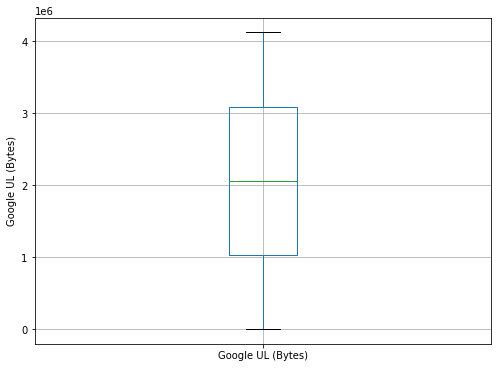

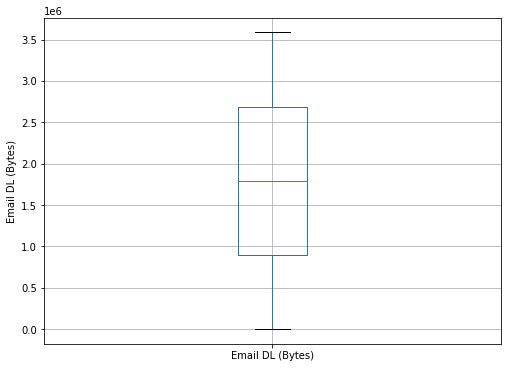

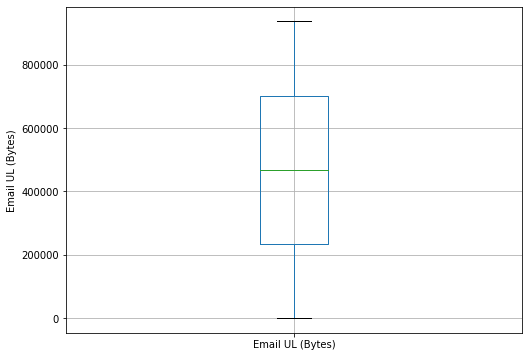

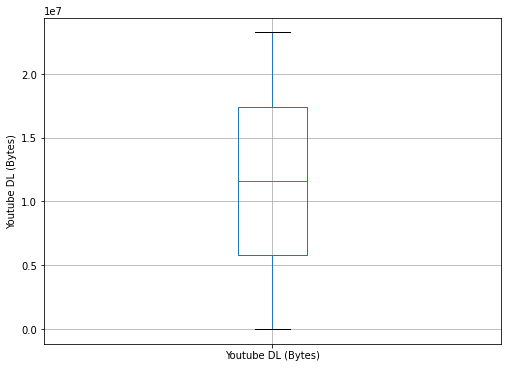

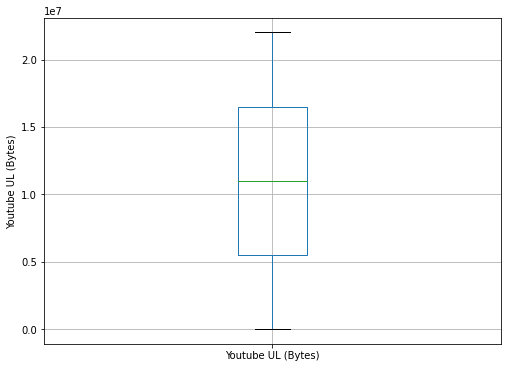

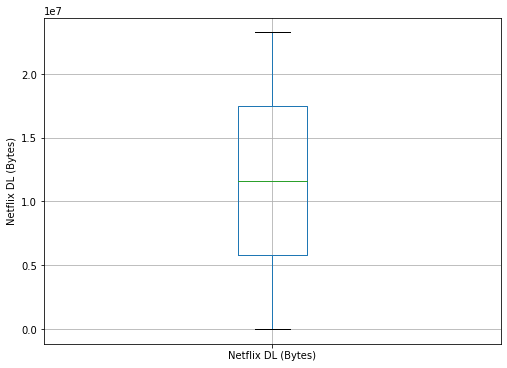

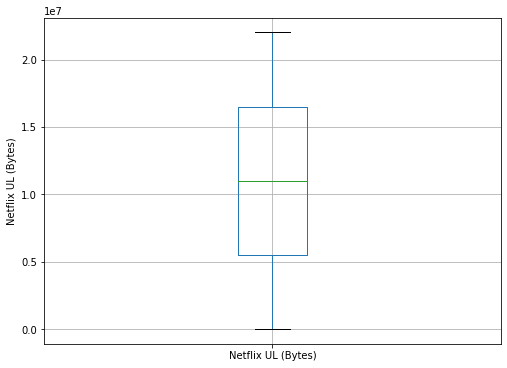

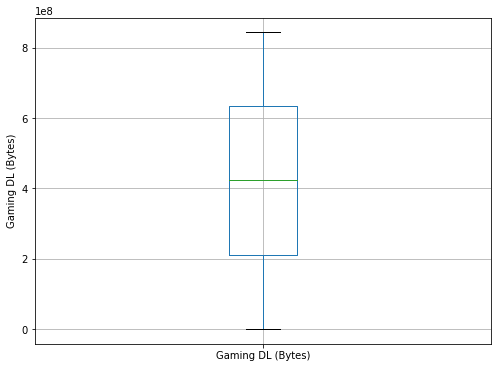

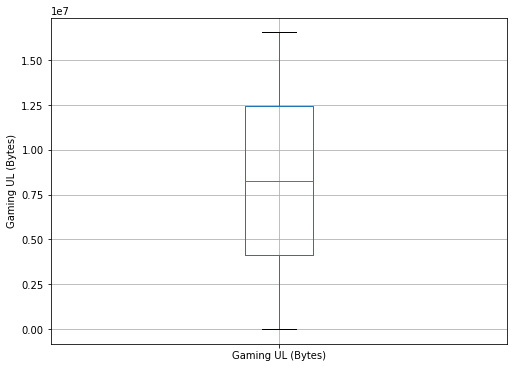

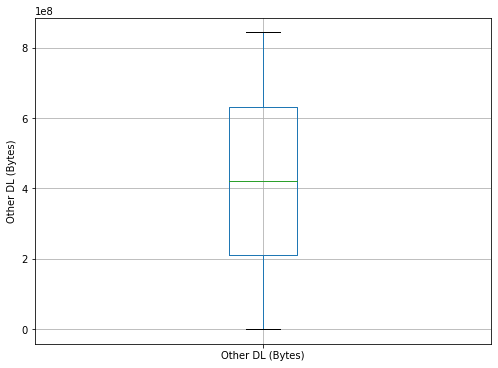

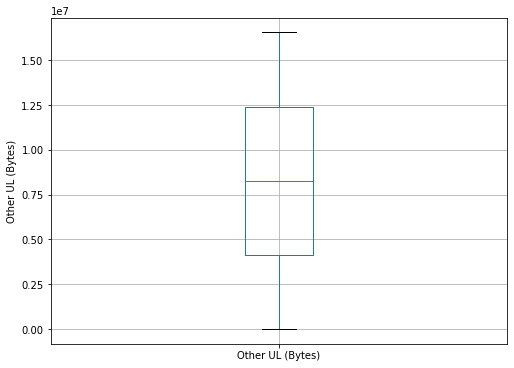

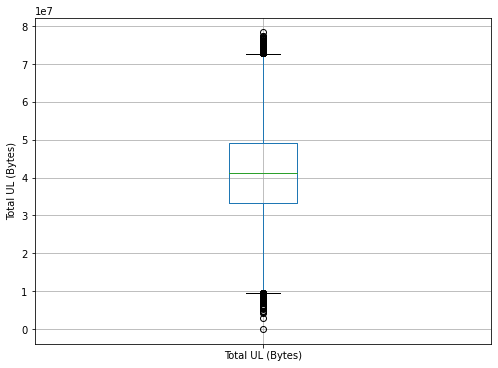

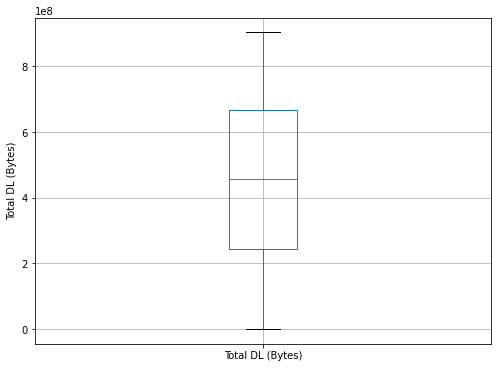

In [81]:
for x in numerical:
    plt.figure(figsize=(18,6))
    plt.subplot(1, 2, 1)
    fig = ds_edited.boxplot(column=x)
    fig.set_title('')
    fig.set_ylabel(x)
    
#     plt.subplot(1, 2, 2)
#     fig = ds_edited[x].hist(bins=20)
#     fig.set_ylabel('MSISDN/Number')
#     fig.set_xlabel(x)

    plt.show()

In [ ]:
#ds_clean = ds.dropna()

In [ ]:
#ds_clean.isna()
#ds_clean.isna().sum()

Now we save the cleaned data in csv format.

In [ ]:
ds_clean.to_csv('cleaned_teleco_data.csv')